# Subject transformation rate

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from pandas import DataFrame
from django.db.models import Count

from gists.models import Sentence, Profile, GistsConfiguration

config = GistsConfiguration.get_solo()

## 2 Transformation rate per subject

First build our data

In [4]:
profiles = Profile.objects\
    .annotate(Count('sentences'))\
    .filter(sentences__count=config.experiment_work + config.training_work,
            user__is_staff=False)
data = []
for distance in Sentence.DISTANCE_TYPES:
    for profile in profiles:
        data.append({
                'username': profile.user.username,
                'prolific': profile.prolific_id,
                'profile_id': profile.id,
                'distance': distance,
                'tr': profile.transformation_rate(distance)
            })
data = DataFrame(data)

In [5]:
for distance in Sentence.DISTANCE_TYPES:
    print('Distance: {}'.format(distance))
    print(data[data.distance == distance].sort_values(by='tr')
          [['username', 'prolific', 'profile_id', 'tr']])
    print()

Distance: raw
                     username                  prolific  profile_id        tr
38                      James  58e3a1700a0f6e0001583a9c          41  0.002875
129                    hayden  57681fca8e454c000133a203         155  0.005859
64                      martr  5809d7202e30a90001da9772          76  0.007720
11                   Laechnor  57c8adc4c6c5ed00013fa2a0          13  0.013352
36                    unicorn  58e627277f27080001eaea4c          39  0.014744
123                    milton  55b35d6ffdf99b7e6a9904c0         148  0.014961
44                Nightmares1  57b2fb9ff0ed6e000151776a          49  0.017305
137                     Iaink  58cc615c27e23a0001b4fe69         165  0.021228
63                     Sharon  589b9715a7d45800010429b6          75  0.024155
119                   Stewart  57f7a412b603d90001945fbb         144  0.031290
130                   abigail  58d92cae33fef3000118a7e9         156  0.031329
35                    hannahj  5714a4b18adadb00128

## 3 Transformation rate distributions

In [6]:
profiles = Profile.objects\
    .annotate(Count('sentences'))\
    .filter(sentences__count=config.experiment_work + config.training_work,
            user__is_staff=False)
data_all = []
for profile in profiles:
    transformed_sentences = (profile.sentences.nonspam.nondoublepost
                             .filter(parent__isnull=False).all())
    for sentence in transformed_sentences:
        for distance in Sentence.DISTANCE_TYPES:
            data_all.append({
                    'username': profile.user.username,
                    'prolific': profile.prolific_id,
                    'profile_id': profile.id,
                    'sentence_id': sentence.id,
                    'distance': distance,
                    'tr': getattr(sentence.parent, distance + '_distance')(sentence)
                })
data_all = DataFrame(data_all)
data_all = data_all

Distribution of all transformation rates together, without zeroes.

In [10]:
DIST_DISTANCE = 'ncoc'

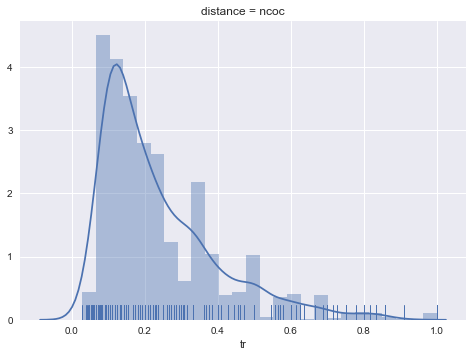

In [11]:
sb.distplot(data_all[(data_all.distance == DIST_DISTANCE) & (data_all.tr > 0)].tr,
            rug=True, kde_kws={'clip': [0, 1]})
plt.gca().set_title('distance = ' + DIST_DISTANCE)

Transformation rate distribution for all profiles, sorted by average transformation rate

Distance = ncoc


/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Error plotting: 0.0 cannot be raised to a negative power


/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2



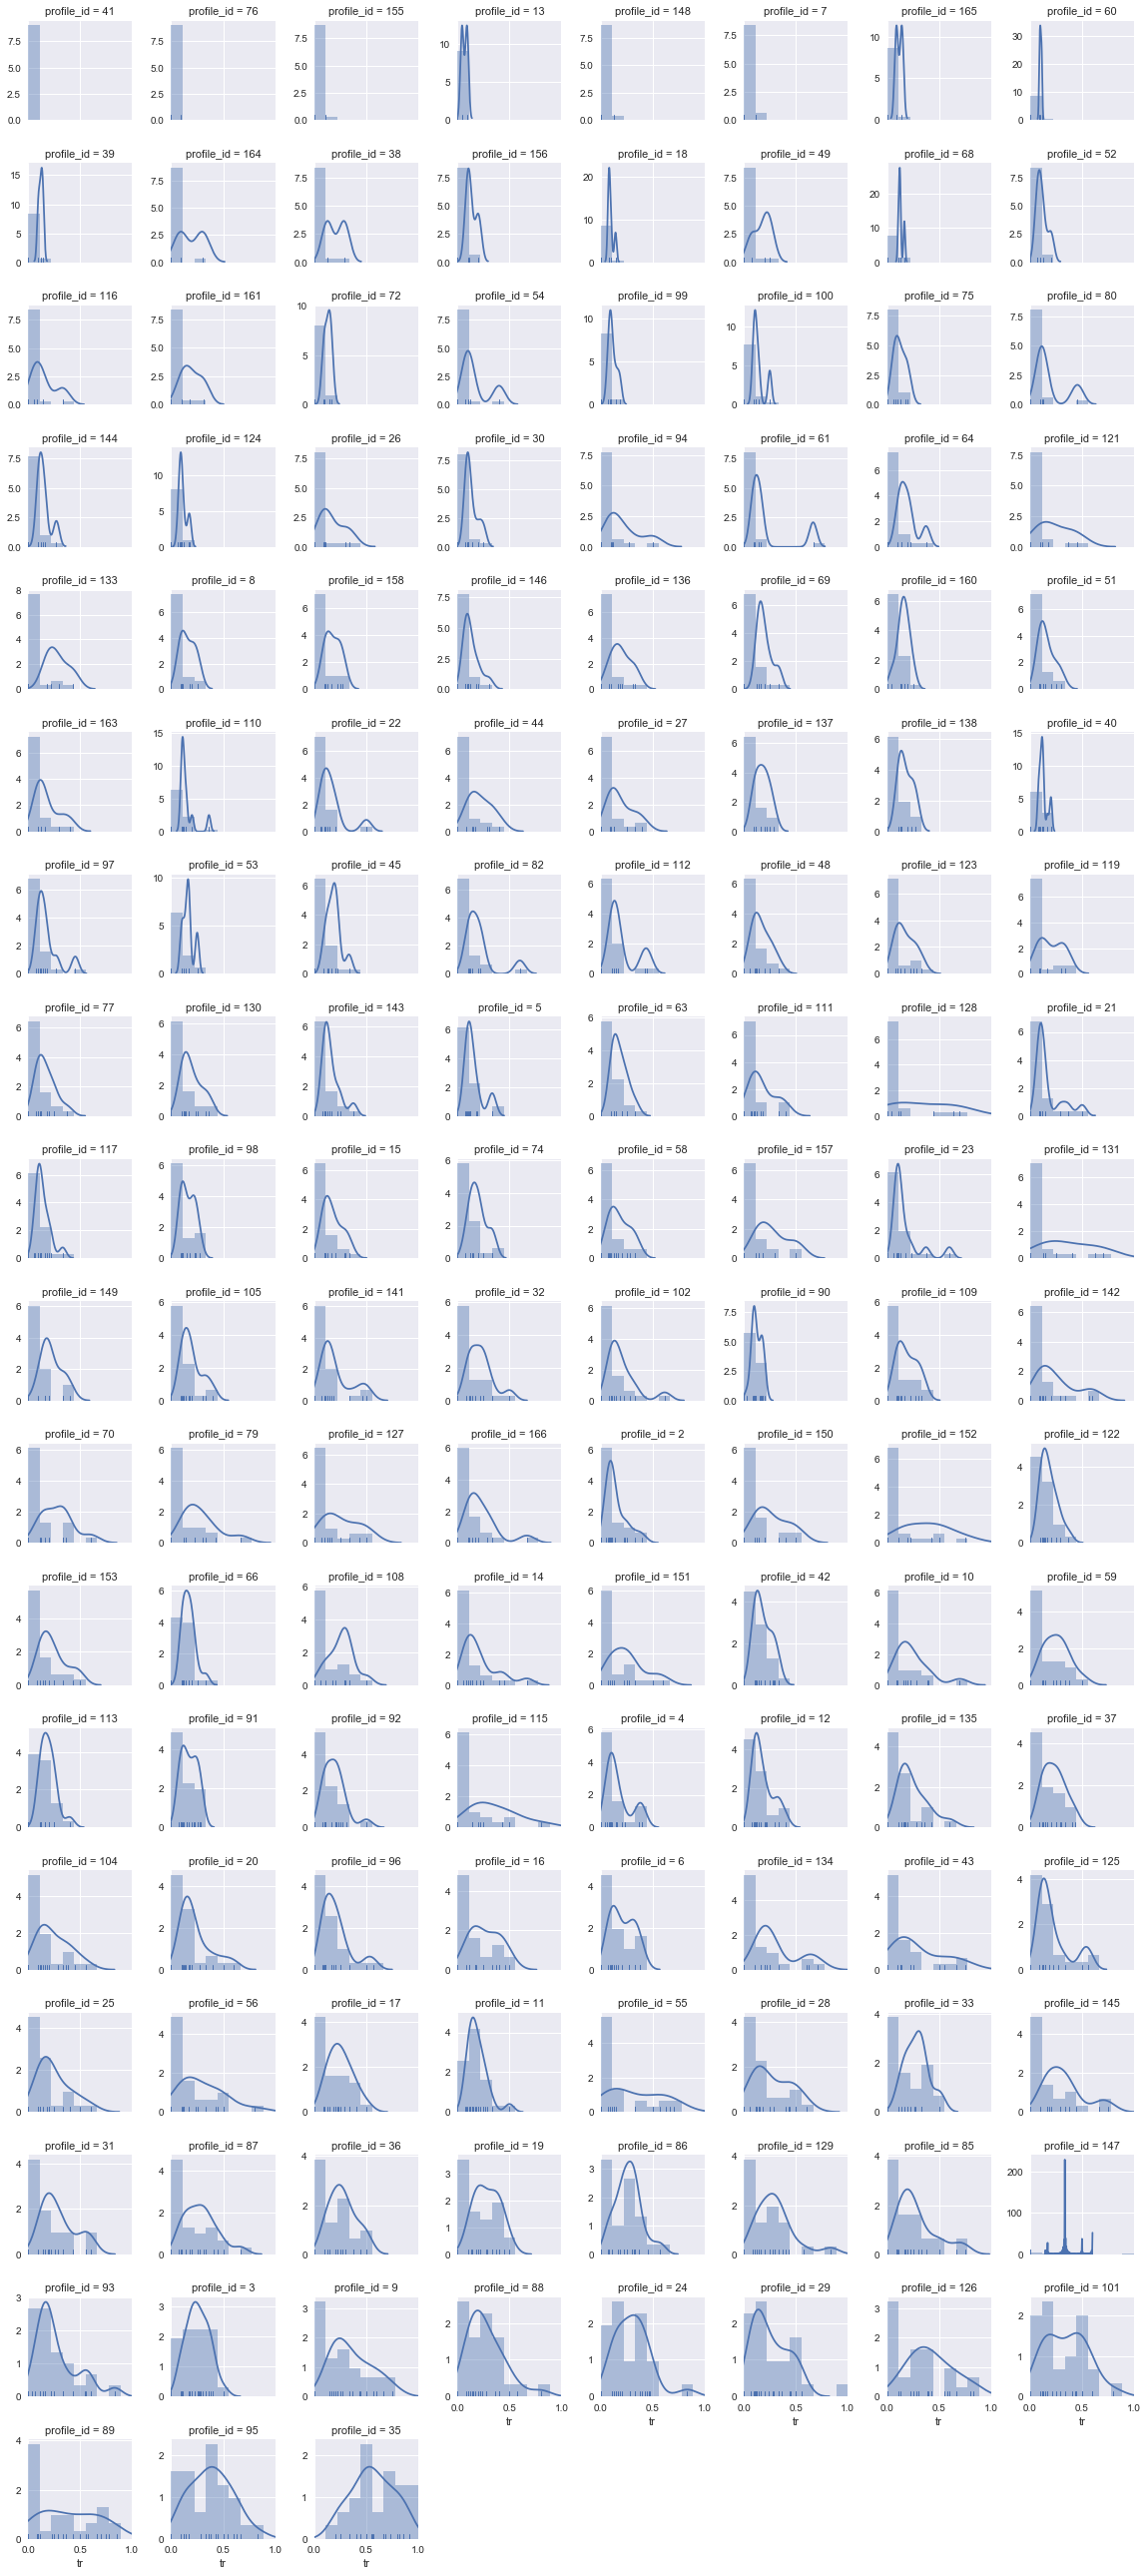

In [20]:
print("Distance = " + DIST_DISTANCE)
g = sb.FacetGrid(data_all[data_all.distance == DIST_DISTANCE],
                 col='profile_id', col_wrap=8, size=2,
                 col_order=data[data.distance == DIST_DISTANCE].sort_values(by='tr').profile_id,
                 sharex=True, sharey=False)

def distplot(*args, **kwargs):
    try:
        sb.distplot(*args, **kwargs)
    except Exception as e:
        print("Error plotting:", e)

g.map(distplot, 'tr', rug=True, bins=np.linspace(0, 1, 10), kde_kws={'clip': [0, 1]})
g.set(xlim=(0, 1))